## Ultimate Inc. Take Home Challenge

### Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).


Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('ultimate_data_challenge.json')

In [3]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Cleaning

In [5]:
df['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [6]:
# simple one hot encode the city names
def rename(x):
    if "King's Landing" in x:
        return 1
    elif 'Astapor' in x:
        return 2
    else:
        return 3


In [7]:
# create new column for one hot labels

df['hot_city'] = df['city'].apply(lambda x: rename(x))

In [8]:
df['trips_in_first_30_days'].describe()

count    50000.000000
mean         2.278200
std          3.792684
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

In [9]:
# create columns for signup date info
df[["signup_year", "signup_month", "signup_day"]] = df["signup_date"].str.split("-", expand = True)

In [11]:
# turn dates into dates
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [12]:
df['signup_date'].describe()

/var/folders/70/gq6zfpsx5rg7k0vsvcbg70_40000gn/T/ipykernel_38952/3414994839.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['signup_date'].describe()


count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

<b> all dates are in January

In [13]:
df['avg_rating_of_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [14]:
df['avg_surge'].unique()

array([1.1 , 1.  , 1.14, 1.19, 1.38, 1.21, 1.17, 1.02, 1.05, 1.5 , 2.  ,
       1.25, 1.04, 1.88, 1.33, 1.56, 1.06, 1.03, 1.09, 1.35, 3.5 , 1.11,
       1.63, 2.5 , 1.32, 1.3 , 1.75, 2.25, 1.2 , 1.13, 1.08, 1.15, 4.  ,
       1.12, 1.22, 1.29, 1.23, 1.01, 1.07, 1.18, 1.45, 2.75, 2.63, 1.46,
       2.07, 1.27, 3.  , 1.36, 1.96, 1.42, 1.44, 1.54, 1.16, 1.31, 1.58,
       1.92, 1.67, 1.26, 4.75, 1.41, 3.25, 1.24, 2.13, 1.6 , 1.57, 1.34,
       1.52, 1.69, 5.  , 1.4 , 1.37, 1.7 , 1.78, 1.43, 1.94, 1.64, 1.83,
       1.28, 1.85, 1.55, 1.48, 1.39, 2.88, 4.25, 1.47, 1.51, 1.9 , 1.68,
       4.5 , 1.66, 2.33, 1.65, 1.71, 2.17, 2.38, 1.61, 2.08, 3.75, 8.  ,
       1.77, 1.49, 2.42, 1.59, 1.8 , 2.19, 1.53, 1.81, 5.75, 1.79, 2.44,
       2.67, 2.31, 2.1 , 2.2 , 3.63])

In [15]:
# create columns for last trip date columns
df[["last_trip_year", "last_trip_month", "last_trip_day"]] = df["last_trip_date"].str.split("-", expand = True)

In [16]:
# turn dates into dates
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [17]:
df['last_trip_date'].describe()

/var/folders/70/gq6zfpsx5rg7k0vsvcbg70_40000gn/T/ipykernel_38952/632557333.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['last_trip_date'].describe()


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [18]:
# retention is based on the past 30 days, the max date will count as today
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [19]:
df['phone'].describe()

count      49604
unique         2
top       iPhone
freq       34582
Name: phone, dtype: object

In [20]:
# simple one hot encode the phone type
def rename_phone(x):
    if "iPhone" in x:
        return 1
    elif 'Android' in x:
        return 2
    else:
        return 3

In [21]:
# fill na
df['phone'] = df['phone'].replace(np.nan,'missing')

In [22]:
# new column for one hot phone
df['hot_phone'] = df['phone'].apply(lambda x: rename_phone(x))

In [23]:
df['surge_pct'].unique()

array([ 15.4,   0. ,  20. ,  11.8,  50. ,  30.8,  33.3,   9.1, 100. ,
         5.8,  22.2,  25. ,   5.4,  10.5,  36. ,  18.2,   5.3,   1.9,
        10. ,  16.7,  15.9,  11.1,   8.3,   2.3,   3.8,  21.4,  22.9,
         3.5,  14.3,  66.7,   2.7,  26.1,   7.1,   7.7,   4.9,  12.5,
        42.9,  17.6,  14.8,  27.3,  20.9,   1.7,  11.7,  13. ,   8.6,
         3. ,   6.5,  40. ,  21.1,   8.1,  10.1,  15.8,   2.4,  36.6,
        71.4,   3.7,   2. ,   5.7,  61.5,   4.3,  34.8,   3.6,  18.8,
         7.5,   6.3,   6.7,  13.5,  19.7,   4.2,  57.1,  14. ,   4.5,
        24.7,   0.9,   5. ,   3.3,  22.6,  12. ,   4.8,  15. ,  37.5,
         5.9,   8.5,   6.8,   2.9,  23.8,  28.6,   1.6,  12.3,  10.3,
        13.3,  27.1,  26.7,  13.6,  11.4,   8. ,  38.5,   2.6,  17.2,
         3.2,  21.7,   9.5,  19.4,  13.8,  55.6,   8.8,   8.9,  16. ,
        18. ,   7.9,   4. ,  23.1,  37.2,  11.6,  60. ,  18.5,  26.3,
         5.6,  12.1,   4.4,  25.3,  10.4,  16.9,  45.1,   2.1,   1.8,
        44.4,  12.9,

In [24]:
df['ultimate_black_user'].describe()

count     50000
unique        2
top       False
freq      31146
Name: ultimate_black_user, dtype: object

In [25]:
# convert the bool values into 1, 0 
df['ultimate_black_user'] = df['ultimate_black_user'] * 1

In [26]:
df['weekday_pct'].describe()

count    50000.000000
mean        60.926084
std         37.081503
min          0.000000
25%         33.300000
50%         66.700000
75%        100.000000
max        100.000000
Name: weekday_pct, dtype: float64

In [27]:
df['avg_dist'].describe()

count    50000.000000
mean         5.796827
std          5.707357
min          0.000000
25%          2.420000
50%          3.880000
75%          6.940000
max        160.960000
Name: avg_dist, dtype: float64

In [28]:
df['avg_rating_by_driver'].describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

### Nan's

In [29]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
hot_city                     0
signup_year                  0
signup_month                 0
signup_day                   0
last_trip_year               0
last_trip_month              0
last_trip_day                0
hot_phone                    0
dtype: int64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  hot_city                50000 non-null  int64 

In [34]:
df['signup_year'] = df['signup_year'].astype('int')
df['signup_month'] = df['signup_month'].astype('int')
df['signup_day'] = df['signup_day'].astype('int')
df['last_trip_year'] = df['last_trip_year'].astype('int')
df['last_trip_month'] = df['last_trip_month'].astype('int')
df['last_trip_day'] = df['last_trip_day'].astype('int')

In [35]:
# rating OF driver
df['avg_rating_of_driver'].mean()

4.6015592912744685

In [36]:
np.nanpercentile(df['avg_rating_of_driver'], 50)

4.9

In [37]:
# severely negative reviews are out weighing the majority
# filling na with the 50th percentile which is 4.9 out of 5
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(4.9)

In [38]:
# rating BY driver
df['avg_rating_by_driver'].mean()

4.778158195947439

In [39]:
np.nanpercentile(df['avg_rating_by_driver'], 50)

5.0

In [40]:
# same method seems fair 
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(5.0)

### Define Retention and find % retained

"we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.""

In [41]:
# function to check if user used in last 30 days
def retention(x):
    today = df['last_trip_date'].max()
    if (today - pd.Timedelta(days=30)) < x:
        return 1
    else:
        return 0

In [42]:
# create retention column
df['active_user'] = df['last_trip_date'].apply(lambda x: retention(x))

In [43]:
# what percent of the january cohort are currently active?
df['active_user'].sum() / df['active_user'].count()

0.3662

In [44]:
df.signup_date

0       2014-01-25
1       2014-01-29
2       2014-01-06
3       2014-01-10
4       2014-01-27
           ...    
49995   2014-01-25
49996   2014-01-24
49997   2014-01-31
49998   2014-01-14
49999   2014-01-18
Name: signup_date, Length: 50000, dtype: datetime64[ns]

### Part 3

# Modeling

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. 
Discuss why you chose your approach, what alternatives you considered, and any concerns you have. 
How valid is your model? Include any key indicators of model performance.

In [45]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'hot_city', 'signup_year', 'signup_month',
       'signup_day', 'last_trip_year', 'last_trip_month', 'last_trip_day',
       'hot_phone', 'active_user'],
      dtype='object')

In [54]:
# define dependent and indepent variables
ultimate_y = df['active_user']
ultimate_X = df.drop(columns=['active_user', 'city', 'phone', 'signup_date', 'last_trip_date', 'last_trip_year', 'last_trip_month'])

In [55]:
ultimate_y.value_counts()

0    31690
1    18310
Name: active_user, dtype: int64

In [56]:
# create test/ train data sets
X_train, X_test, y_train, y_test = train_test_split(ultimate_X, ultimate_y, test_size=0.2, random_state=9)

### Random Forest Classifier

In [76]:
# random forest classifier with stock settings

RFC = RandomForestClassifier(n_estimators=1000, criterion='entropy', class_weight={0:1,1:15})
RFC_model = RFC.fit(X_train, y_train)
RFC_pred = RFC_model.predict(X_test)
RFC_model.score(X_train, y_train)

1.0

In [77]:
accuracy_score(y_test, RFC_pred)

0.8069

In [78]:
confusion_matrix(y_test, RFC_pred)

array([[5593,  751],
       [1180, 2476]])

In [79]:
print(classification_report(y_test, RFC_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      6344
           1       0.77      0.68      0.72      3656

    accuracy                           0.81     10000
   macro avg       0.80      0.78      0.79     10000
weighted avg       0.80      0.81      0.80     10000



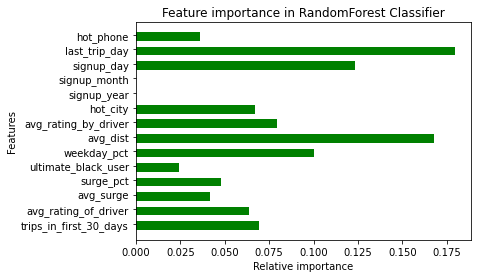

In [61]:
# models .feature_importance_

y = RFC_model.feature_importances_

fig, ax = plt.subplots() 
width = 0.6 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups

ax.barh(ind, y, width, color="green")
ax.set_yticks(ind+width/5)

ax.set_yticklabels(ultimate_X, minor=False, fontsize=10)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('Features') 
plt.show()



### Support Vector Machine

In [62]:
# support vector machine
# polynomial

svm_model = svm.SVC(kernel='poly', degree=2)
svm_model_fit = svm_model.fit(X_train, y_train)
svm_pred_poly = svm_model_fit.predict(X_test)

In [63]:
accuracy_score(y_test, svm_pred_poly)

0.6344

In [64]:
confusion_matrix(y_test, svm_pred_poly)

array([[6344,    0],
       [3656,    0]])

In [65]:
print(classification_report(y_test, svm_pred_poly))

              precision    recall  f1-score   support

           0       0.63      1.00      0.78      6344
           1       0.00      0.00      0.00      3656

    accuracy                           0.63     10000
   macro avg       0.32      0.50      0.39     10000
weighted avg       0.40      0.63      0.49     10000



/Users/joe/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joe/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joe/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusion

I ran both SVM at the same time, but SVM was not as good as Random Forest. This is because SVM was not actually very good at predicting active users. It seems like SVM is taking short cuts and just picking not-active as a means to increase accuracy.

Random Forest Classifier wins.

### from above

In [66]:
print('accuracy: ',accuracy_score(y_test, RFC_pred),' confusion matrix ',confusion_matrix(y_test, RFC_pred))

accuracy:  0.8071  confusion matrix  [[5591  753]
 [1176 2480]]


In [67]:
print(classification_report(y_test, RFC_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      6344
           1       0.77      0.68      0.72      3656

    accuracy                           0.81     10000
   macro avg       0.80      0.78      0.79     10000
weighted avg       0.80      0.81      0.80     10000



I chose the parameters for random forest based on what the desired outcome was. Only a few of the hyperparameters made a positive impact on results.  

Changing the criterion to entropy improved accuracy by about half a percent.
Increasing the number of trees also improved accuracy.

Adding class weighting slightly made a difference.  balanced was better than balanced_subsample so I increased the weight of the class 1 to 5, 10, 20, 15 to see if increased weighting would increase favoritism of the smaller desired class. 10 was the best of the tested criteria.


A concern I have is that both models were better at selecting non-active users.  I also am not sure what would qualify as a great predictive number. Obviously 100% accuracy, precision, recall would be amazing but 0.81

I also keep referring to accuracy because the classification report is consistent. The random forest model does not appear to be cheating and selecting 0 because 0 occurs more.

## 3.

Insights Ultimate could use include: Most import features are avg distance traveled, rating by driver, and weekday pct.

This model could be used to help determine an estimate of service use and whether or not to advertise or hire drivers to fill a need.

Even though there are still some black box answers in there, meaning exactly what about these three criterias the model liked is unclear. Weekday riders, and avg trip distance  data could be fabricated and run through the same model to determine how the model treats these values as predictive factors.  

My guess is that longer trips people are less likely to walk and weekday riders use this to get to work sometimes and probably will continue to use this service as long as they have that specific job.

